# Stefan Problem - test melting and solidification

Step 1 - import packages

In [1]:
# Importing (using/include) packages and files needed for the code to run
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
using SpecialFunctions
using Roots
using NLsolve
using Printf
using HDF5
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")
include("Topo.jl")

# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

Step 2 - Define a function that relates entropy and temperature/pressure. 
$$
T = f_1(P,S)
$$

$$
T = \exp \left( \frac{S}{C_V} + \ln (T_{ref}) - \frac{\Delta H_{fus} }{C_V T_M}X \right)
$$

and 
$$
S = f_2(P,T)
$$
$$
S = C_V (\ln (T) - \ln(T_{ref})) + \frac{\Delta H_{fus}}{T_m}X
$$

In [2]:
# functions that relates entropy and temperature/pressure are define in TemperatureEntropy.jl file
include("TemperatureEntropy.jl")

update_melt_fraction (generic function with 1 method)


Step 3 - Write functions to set up the initial condition for the Stefan problem

- Consider a box with width 100 km and height 100 km.
- The box is filled entirely with one material
- Initially, the top 10 km is solid and the bottom 90 km is liquid.
- The sides are insulating
- Density is constant and equal to 1000 kg/m$^3$
- The surface is at T=100K, the bottom is at T=273 K
- The liquid is isothermal with $T=T_m$.
- The solid has initial $T(z)$ given by the Stefan solution (Turcotte and Schubert section 4.18)
$$
\theta = \frac{erf(\eta)}{erf(\lambda_1)}
$$
- Given the initial temperature, compute initial entropy S on the markers.
  

In [3]:
# functions that setup the initial condition for the stefan problem are define in TemperatureEntropy.jl file

function initial_ice_depth(x::Float64)
    return 1e4
end 

struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,1000.0],[0.0,0.0,0.0],[4180.0,2100.0],[0.5610,2.2])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
    end
end

function update_marker_temp!(markers::Markers,materials::Materials)
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 1 
            markers.scalars[T,i] = 273.0
        end 
    end 
end 

function initial_conditions!(markers::Markers,materials::Materials,options::Dict)
    material = markers.integerFields["material"]
    S = markers.scalarFields["S"]
    X = markers.scalarFields["melt fraction"]
    T = markers.scalarFields["T"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    
    # Setting up Stefan conidtion
    lambda1 = get_lambda1(options)
    t = get_t(lambda1,options)
    
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            markers.scalars[X,i] = 0.0
            markers.scalars[S,i] = entropy_of_P_T(markers.scalars[X,i],markers.scalars[T,i],options)
        elseif my < hice
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = stefan_initial_condition(get_theta(my,t,lambda1),options)
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]
            markers.scalars[kThermal,i] = materials.kThermal[2]
            markers.scalars[X,i] = 1.0
            markers.scalars[S,i] = entropy_of_P_T(markers.scalars[X,i],markers.scalars[T,i],options)
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

initial_conditions! (generic function with 1 method)

# Main part of code
- At each timestep, begin by computing T(S,X) on the markers
- Iteratively solve the temperature equation. Start with a guess S_new = S_old
    - For T_new, compute $q_{cond} = \nabla \cdot (k \nabla T_{new})$
    - Solve diffusion equation for S_new
    - Given S_new, update T_new
    - Iterate until converged...
- Given the new entropy solution on the cell centers, update the entropy and melt fraction on the markers.

In [4]:
function run(options::Dict)
    W = 1e5
    H = 1e5
    ny = 101
    nx = Int64(ceil(W/H*ny))
    gx = 0.0
    gy = 0.113

    Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
    materials = Materials()
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","Cp","Hr","kThermal","S","melt fraction"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers,materials,options)

    i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")

    ### Setting up agruments for termination criteria ###
    max_step::Int64=1
    max_time::Float64=-1.0
    max_time = max_time == -1.0 ? typemax(Float64) : max_time
    max_step = max_step == -1 ? typemax(Int64) : max_step

    time = 0.0
    iout= 0
    last_plot = 0.0
    dt = 1e10

    rho_c = nothing
    rho_vx = nothing 
    rho_vy = nothing 
    alpha = nothing
    Hr = nothing
    Cp_c = nothing
    T = nothing
    S = nothing
    dTmax = nothing
    dTemp = nothing
    Tnew = nothing
    S_new = nothing
    Tlast = nothing
    kThermal = nothing
    S_last = nothing
    mat = nothing
    kThermal_vx = nothing
    kThermal_vy = nothing
    X_last = nothing

    itime = 1 
    terminate = false
    while !terminate
        # 0. update the markers properties
        update_marker_prop!(markers,materials)
        update_marker_temp!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        # eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic",method="logarithmic")
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,Hr_new,kThermal_new,S_last_new,X_last_new, = marker_to_stag(markers,grid,["rho","Cp","alpha","Hr","kThermal","S","melt fraction"],"center")
        # eta_n_new, = marker_to_stag(markers,grid,["eta",],"center",method="logarithmic")
        # interpolate temperature using rhocp as weight
        rhocp = markers.scalars[markers.scalarFields["rho"],:] .* markers.scalars[markers.scalarFields["Cp"],:]
        Tlast_new, = marker_to_stag(markers,grid,["T"],"center",extra_weight = rhocp)
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")
        kThermal_vx_new, = marker_to_stag(markers,grid,["kThermal",],"vx")
        kThermal_vy_new, = marker_to_stag(markers,grid,["kThermal",],"vy")
        
        # deal with any NaN values from interpolation:
        if itime > 1
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
            replace_nan!(kThermal,kThermal_new)
            replace_nan!(S_last,S_last_new)
            replace_nan!(kThermal_vx,kThermal_vx_new)
            replace_nan!(kThermal_vy,kThermal_vy_new)
            replace_nan!(X_last,X_last_new)
        end
        # Copy field data
        kThermal = copy(kThermal_new)
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        Tlast = copy(Tlast_new)    
        S_last = copy(S_last_new)
        kThermal_vx = copy(kThermal_vx_new)
        kThermal_vy = copy(kThermal_vy_new)
        X_last = copy(X_last_new)

        display(X_last)
        
        if itime == 1
            ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
        else
            ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
        end

        # q_cond_x = compute_q_cond(grid,Tlast,kThermal_vx,"vx")
        # q_cond_y = compute_q_cond(grid,Tlast,kThermal_vy,"vy")        

        # figure()
        # title(L"q_{cond}\,\,at\,\,vx")
        # pcolor(q_cond_x,cmap="viridis")
        # colorbar().set_label(label=L"q_{vx}",rotation=0,labelpad=15)
        # gca().invert_yaxis()
        # gca().spines["top"].set_visible(false) # Hide the top edge of the axis
        # gca().spines["right"].set_visible(false) # Hide the right edge of the axis
        # gca().xaxis.set_ticks_position("bottom")
        # gca().yaxis.set_ticks_position("left")
        # gca().spines["left"].set_position(("axes",-0.03)) # Offset the left scale from the axis
        # gca().spines["bottom"].set_position(("axes",-0.03)) # Offset the bottom scale from the axis
        # gca().spines["top"].set_color("none") # Remove the top axis boundary
        # gca().spines["right"].set_color("none") # Remove the right axis boundary
        # tight_layout()
        # show()

        # figure()
        # title(L"q_{cond}\,\,at\,\,vy")
        # pcolor(q_cond_y,cmap="viridis")
        # colorbar().set_label(label=L"q_{vy}",rotation=0,labelpad=15)
        # gca().invert_yaxis()
        # gca().spines["top"].set_visible(false) # Hide the top edge of the axis
        # gca().spines["right"].set_visible(false) # Hide the right edge of the axis
        # gca().xaxis.set_ticks_position("bottom")
        # gca().yaxis.set_ticks_position("left")
        # gca().spines["left"].set_position(("axes",-0.03)) # Offset the left scale from the axis
        # gca().spines["bottom"].set_position(("axes",-0.03)) # Offset the bottom scale from the axis
        # gca().spines["top"].set_color("none") # Remove the top axis boundary
        # gca().spines["right"].set_color("none") # Remove the right axis boundary
        # tight_layout()
        # show()

        S_max = Inf
        dS = nothing
        S_new = nothing
        Tnew = nothing
        X_new = nothing
        titer = 1
        for titer=1:2
            println("Trying with timestep ",dt/seconds_in_year/1e3," kyr")
            q_cond_x = compute_q_cond(grid,Tlast,kThermal_vx,"vx")
            q_cond_y = compute_q_cond(grid,Tlast,kThermal_vy,"vy") 
            # println("Size of Tlast is ",size(Tlast))
            # println("Size of rho is ",size(rho_c_new))
            # println("Size of Hr is ",size(Hr))
            # println("Size of qx is ",size(q_cond_x))
            # println("Size of qy is ",size(q_cond_y))
            # println("Size of Slast is ",size(S_last))
            S_new = compute_S_new(grid,Tlast,rho_c_new,Hr,q_cond_x,q_cond_y,S_last,dt);
            figure()
            title("Entropy")
            pcolor(S_new,cmap="viridis")
            colorbar().set_label(label=L"J/K",rotation=0)
            gca().invert_yaxis()
            show()
            Tnew = temp_of_P_S(X_last,S_new,options)
            display(Tnew)
            X_new = update_melt_fraction(grid,Tnew)
            display(X_new)
            S = copy(S_new)
            Tlast = copy(Tnew)
            X_last = copy(X_new)
        end
             
        # mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
        
        # Checking Termination Criteria, time is in Myr, amplitude is in meters
        if time >= max_time || itime >= max_step 
            terminate = true
        end
        time += dt
        itime += 1
        println("Finished Step ",itime," time=",time/seconds_in_year/1e3," kyr")
    end
    return grid,i_mat,markers
end

run (generic function with 1 method)

Creating Markers...
  0.031191 seconds (19 allocations: 40.376 MiB, 74.09% gc time)
Initial condition...
  2.323745 seconds (10.54 M allocations: 323.408 MiB, 9.77% gc time, 86.68% compilation time)


102×102 Matrix{Float64}:
 1.0    1.0    1.0    1.0    1.0    …  1.0    1.0    1.0    1.0    1.0
 1.0    1.0    1.0    1.0    1.0       1.0    1.0    1.0    1.0    1.0
 1.0    1.0    1.0    1.0    1.0       1.0    1.0    1.0    1.0    1.0
 1.0    1.0    1.0    1.0    1.0       1.0    1.0    1.0    1.0    1.0
 1.0    1.0    1.0    1.0    1.0       1.0    1.0    1.0    1.0    1.0
 1.0    1.0    1.0    1.0    1.0    …  1.0    1.0    1.0    1.0    1.0
 1.0    1.0    1.0    1.0    1.0       1.0    1.0    1.0    1.0    1.0
 1.0    1.0    1.0    1.0    1.0       1.0    1.0    1.0    1.0    1.0
 1.0    1.0    1.0    1.0    1.0       1.0    1.0    1.0    1.0    1.0
 1.0    1.0    1.0    1.0    1.0       1.0    1.0    1.0    1.0    1.0
 0.875  0.875  0.875  0.875  0.875  …  0.875  0.875  0.875  0.875  0.875
 0.125  0.125  0.125  0.125  0.125     0.125  0.125  0.125  0.125  0.125
 0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 ⋮                                  ⋱           

Trying with timestep 0.31746031746031744 kyr


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


102×102 Matrix{Float64}:
  0.908999    -0.0910012   -0.0910012   …  -0.0911293    0.438941
 -0.091002     0.908998    -0.091002       -0.0903088    0.363577
 -0.0910034   -0.0910034    0.908997       -0.0904026    0.216727
 -0.0910047   -0.0910047   -0.0910047      -0.0906353    0.0768578
 -0.0910059   -0.0910059   -0.0910059      -0.0908209   -0.0434469
 -0.0910069   -0.0910069   -0.0910069   …  -0.0909733   -0.147915
 -0.0910078   -0.0910078   -0.0910078      -0.0911015   -0.239207
 -0.0910086   -0.0910086   -0.0910086      -0.091211    -0.319305
 -0.0910093   -0.0910093   -0.0910093      -0.0913059   -0.389739
 -0.0910099   -0.0910099   -0.0910099      -0.0913686   -0.451727
 -0.0796326   -0.0796326   -0.0796326   …  -0.080327    -0.438793
 -0.011366    -0.011366    -0.011366       -0.0114851   -0.065379
  1.17585e-5   1.17585e-5   1.17585e-5      1.18833e-5  -6.59642e-6
  ⋮                                     ⋱   ⋮           
  1.17585e-5   1.17585e-5   1.17585e-5  …   1.18833e-5  

102×102 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

Trying with timestep 0.31746031746031744 kyr


102×102 Matrix{Float64}:
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  …  Inf  Inf  Inf  Inf  Inf  Inf  Inf
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     Inf  Inf  Inf  Inf  Inf  Inf  Inf
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     Inf  Inf  Inf  Inf  Inf  Inf  Inf
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     Inf  Inf  Inf  Inf  Inf  Inf  Inf
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     Inf  Inf  Inf  Inf  Inf  Inf  Inf
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  …  Inf  Inf  Inf  Inf  Inf  Inf  Inf
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     Inf  Inf  Inf  Inf  Inf  Inf  Inf
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     Inf  Inf  Inf  Inf  Inf  Inf  Inf
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     Inf  Inf  Inf  Inf  Inf  Inf  Inf
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     Inf  Inf  Inf  Inf  Inf  Inf  Inf
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  …  Inf  Inf  Inf  Inf  Inf  Inf  Inf
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     Inf  Inf  Inf  Inf  Inf  Inf  Inf
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf

102×102 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

Finished Step 2 time=0.31746031746031744 kyr


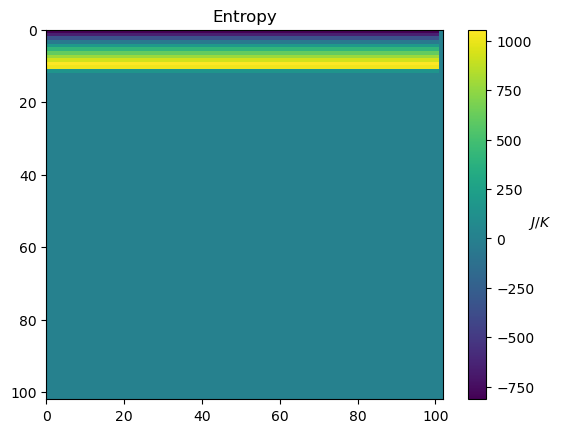

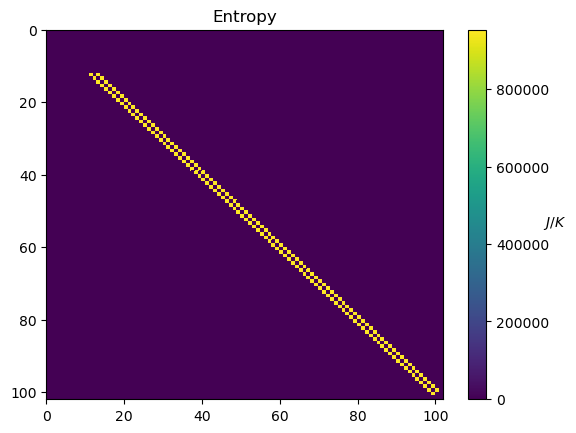

In [5]:
options = Dict()
options["latent heat of fusion"] = 3.34e5 # J/kg
options["specific heat"] = 2.1e3 # J/kg*K
options["Tm"] = 273.0 # K
options["To"] = 100.0 # K 
options["thermal diffusivity"] = 2.2/(1000.0*options["specific heat"]) # m^2/s
options["ym"] = 1e4 # m 
options["Tref"] = 273.0 # K
grid,i_mat,markers = run(options);

In [ ]:
figure()
title(L"Initial\,\,Model\,\,Schematic")
pcolor(grid.xc/1000,grid.yc/1000,i_mat,cmap="viridis")
colorbar().set_label(label=L"material(id)",rotation=0,labelpad=35)
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(km)",rotation=0,labelpad=30)
gca().set_xlabel(L"Width\,(km)")
# gca().yaxis.set_label_position("left")
gca().spines["top"].set_visible(false) # Hide the top edge of the axis
gca().spines["right"].set_visible(false) # Hide the right edge of the axis
# gca().yaxis.tick_right()
gca().xaxis.set_ticks_position("bottom")
gca().yaxis.set_ticks_position("left")
gca().spines["left"].set_position(("axes",-0.03)) # Offset the left scale from the axis
gca().spines["bottom"].set_position(("axes",-0.03)) # Offset the bottom scale from the axis
gca().spines["top"].set_color("none") # Remove the top axis boundary
gca().spines["right"].set_color("none") # Remove the right axis boundary
tight_layout()
show()

figure()
title(L"Temperature\,\,Profile")
scatter(markers.x[1,:]/1000,markers.x[2,:]/1000,c=markers.scalars[markers.scalarFields["T"],:],s=0.1,cmap="viridis")
colorbar().set_label(label=L"K",rotation=0,labelpad=15)
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(km)",rotation=0,labelpad=30)
gca().set_xlabel(L"Width\,(km)")
# gca().yaxis.set_label_position("left")
gca().spines["top"].set_visible(false) # Hide the top edge of the axis
gca().spines["right"].set_visible(false) # Hide the right edge of the axis
# gca().yaxis.tick_right()
gca().xaxis.set_ticks_position("bottom")
gca().yaxis.set_ticks_position("left")
gca().spines["left"].set_position(("axes",-0.03)) # Offset the left scale from the axis
gca().spines["bottom"].set_position(("axes",-0.03)) # Offset the bottom scale from the axis
gca().spines["top"].set_color("none") # Remove the top axis boundary
gca().spines["right"].set_color("none") # Remove the right axis boundary
tight_layout()
show()

figure()
title(L"Entropy\,\,Profile")
scatter(markers.x[1,:]/1000,markers.x[2,:]/1000,c=markers.scalars[markers.scalarFields["S"],:],s=0.1,cmap="viridis")
colorbar().set_label(label=L"J/K",rotation=0,labelpad=15)
gca().invert_yaxis()
# gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(km)",rotation=0,labelpad=30)
gca().set_xlabel(L"Width\,(km)")
# gca().yaxis.set_label_position("left")
gca().spines["top"].set_visible(false) # Hide the top edge of the axis
gca().spines["right"].set_visible(false) # Hide the right edge of the axis
# gca().yaxis.tick_right()
gca().xaxis.set_ticks_position("bottom")
gca().yaxis.set_ticks_position("left")
gca().spines["left"].set_position(("axes",-0.03)) # Offset the left scale from the axis
gca().spines["bottom"].set_position(("axes",-0.03)) # Offset the bottom scale from the axis
gca().spines["top"].set_color("none") # Remove the top axis boundary
gca().spines["right"].set_color("none") # Remove the right axis boundary
tight_layout()
show()